# File and libraries

In [14]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_ecom_DT_final"

# DSLabs functions

In [34]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [33]:
%run "data_functions.py"


data_functions loaded


# Load

In [15]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    df = df.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    # data=data.sample(frac=0.05, replace=False)
    # test=test.sample(frac=0.05, replace=False)
    # train=train.sample(frac=0.05, replace=False)
    
    
else:
    df=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # larger sample 10%
    # data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)

 
target='is_purchase'
taget_metric = 'f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258334 entries, 0 to 258333
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  258334 non-null  float64
 1   category_code_lvl_2  258334 non-null  float64
 2   price                258334 non-null  float64
 3   is_purchase          258334 non-null  int64  
 4   activity_in_session  258334 non-null  float64
 5   week_of_month        258334 non-null  int64  
 6   is_weekend           258334 non-null  int64  
 7   day                  258334 non-null  int64  
 8   brand_value          258334 non-null  float64
 9   product_category     258334 non-null  int64  
 10  time_of_day_sin      258334 non-null  float64
 11  time_of_day_cos      258334 non-null  float64
 12  day_of_week_sin      258334 non-null  float64
 13  day_of_week_cos      258334 non-null  float64
 14  hour_sin             258334 non-null  float64
 15  hour_cos             2

# Distribution Check

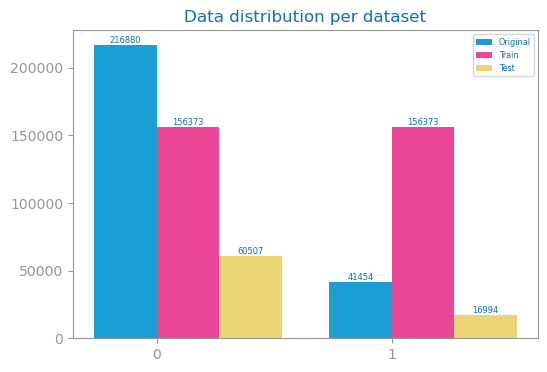

In [16]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [ ]:

from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# adapted to read from memory
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Reads training and test data from either CSV files or DataFrames, and splits
    the data into features and target.

    Parameters:
    -----------
    train_fn : Union[str, DataFrame]
        File path to the training CSV or a DataFrame object.
    test_fn : Union[str, DataFrame]
        File path to the test CSV or a DataFrame object.
    target : str, default="class"
        The name of the target column.

    Returns:
    --------
    tuple : (trnX, tstX, trnY, tstY, labels, features)
        - trnX: Training feature set as ndarray.
        - tstX: Test feature set as ndarray.
        - trnY: Training labels as array.
        - tstY: Test labels as array.
        - labels: List of unique target values.
        - features: List of feature names (column names).
    """
    # Check if train_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Use the provided DataFrame directly

    # Extract and sort unique target labels
    labels: list = list(train[target].unique())
    labels.sort()

    # Separate features (X) and target (Y) for training data
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Check if test_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Use the provided DataFrame directly

    # Separate features (X) and target (Y) for test data
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()



In [28]:
from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# Função para ler os dados de treino e teste
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Lê dados de treino e teste de arquivos CSV ou DataFrames e separa as características e o alvo.

    (Documentação da função...)
    """
    # Verificar se train_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Extrair e ordenar os rótulos de alvo únicos
    labels: list = list(train[target].unique())
    labels.sort()

    # Separar características (X) e alvo (Y) para dados de treino
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Verificar se test_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Separar características (X) e alvo (Y) para dados de teste
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

# Exemplo de uso da função
if evaluate == True:
    # Verifica o tipo de train e test
    print(f'Train: {train}, type: {type(train)}')  # Verifica o tipo de train
    print(f'Test: {test}, type: {type(test)}')      # Verifica o tipo de test

    # Lê os dados usando a função
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)

    # Exibe as informações lidas
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')


Train:         category_code_lvl_1  category_code_lvl_2    price  \
0                       0.0                  3.0   949.47   
2279                    0.0                  3.0    88.28   
2280                    0.0                  3.0   218.54   
2281                    0.0                  3.0  1348.32   
2282                    0.0                  3.0   782.22   
...                     ...                  ...      ...   
310952                  0.0                  3.0   108.63   
310953                  0.0                  3.0   771.94   
310954                  0.0                  6.0   321.73   
310946                  0.0                  3.0   535.15   
312745                  6.0                 42.0    95.24   

        activity_in_session  week_of_month  is_weekend   day  brand_value  \
0                  3.000000            1.0         0.0   1.0        779.2   
2279               0.000000            1.0         0.0   1.0        282.5   
2280               5.000000  

In [29]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=312746 Test#=77501
Labels=[0, 1]


## recall evaluation

DT best with gini and d=4


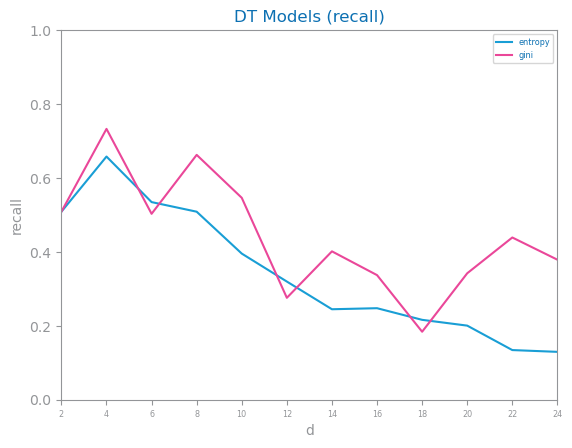

In [35]:
if evaluate==True:

    best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='recall')
    savefig(f'images/{file_tag}_dt_recall_study.png')
    show()

## evaluate precision

DT best with gini and d=12


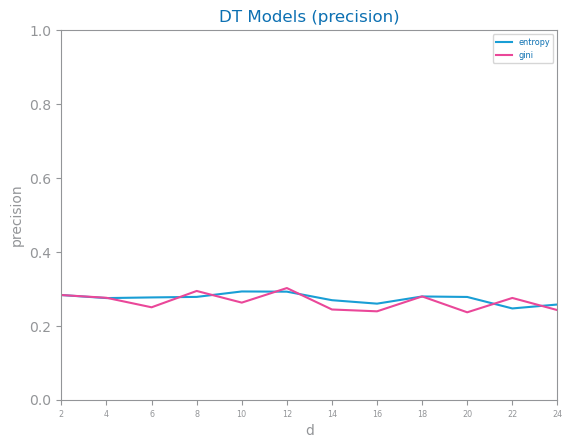

In [36]:
if evaluate==True:

    best_model_prec, prec_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='precision')
    savefig(f'images/{file_tag}_dt_precision_study.png')
    show()

## evaluate accuracy

DT best with entropy and d=20


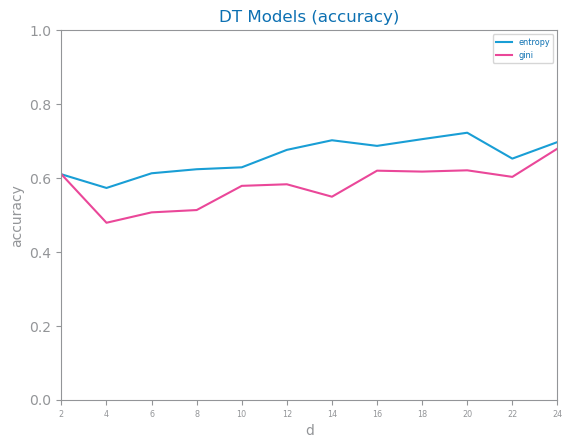

In [37]:
if evaluate==True:

    best_model_fl, fl_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='accuracy')
    savefig(f'images/{file_tag}_dt_accuracy_study.png')
    show()

## Evaluate for best model - Decision Trees

DT best with gini and d=6


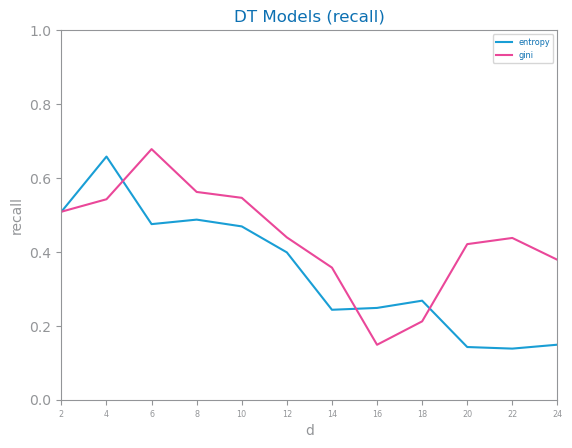

In [38]:
if evaluate==True:

    figure()

    eval_metric = 'recall'

    best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
    savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
    show()

# Best Model Performance

<Figure size 640x480 with 0 Axes>

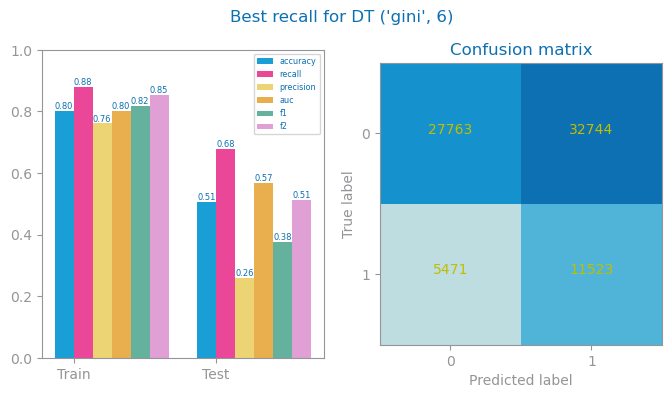

In [40]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

# Variables importance

# IF YOU HAVE AN ERROR YOU MAY NEED TO INSTALL GRAPHVIZ

1. open conda terminal
2. conda install graphviz

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.945547 to fit


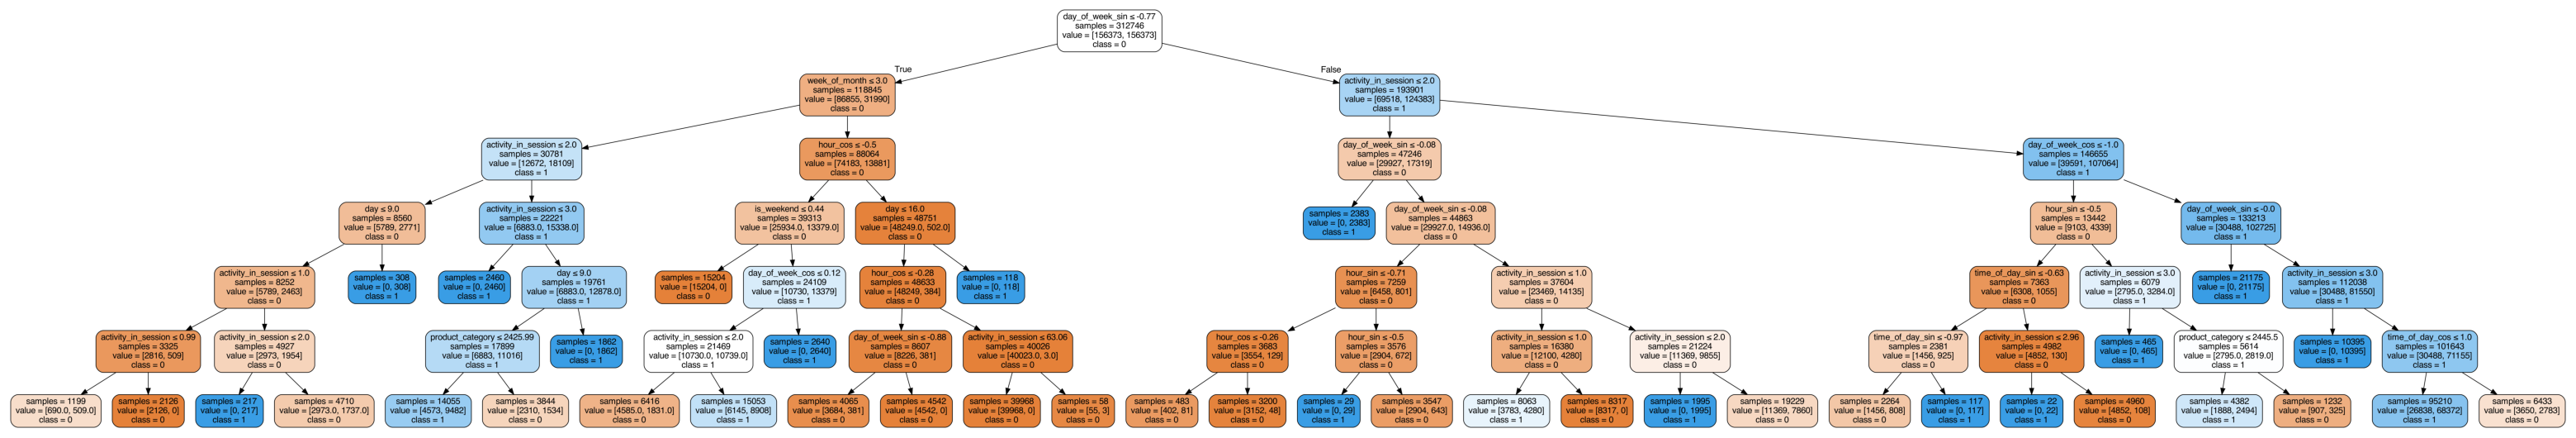

In [47]:
if evaluate==True:
    from sklearn.tree import export_graphviz
    from matplotlib.pyplot import imread, imshow, axis
    from subprocess import call

    tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
    max_depth2show = 8
    st_labels: list[str] = [str(value) for value in labels]

    dot_data: str = export_graphviz(
        best_model,
        out_file=tree_filename + ".dot",
        max_depth=max_depth2show,
        feature_names=vars,
        class_names=st_labels,
        filled=True,
        rounded=True,
        impurity=False,
        special_characters=True,
        precision=2,
    )
    # Convert to png
    call(
        ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
    )

    figure(figsize=(40, 30))
    imshow(imread(tree_filename + ".png"))
    axis("off")
    show()

## simpler tree

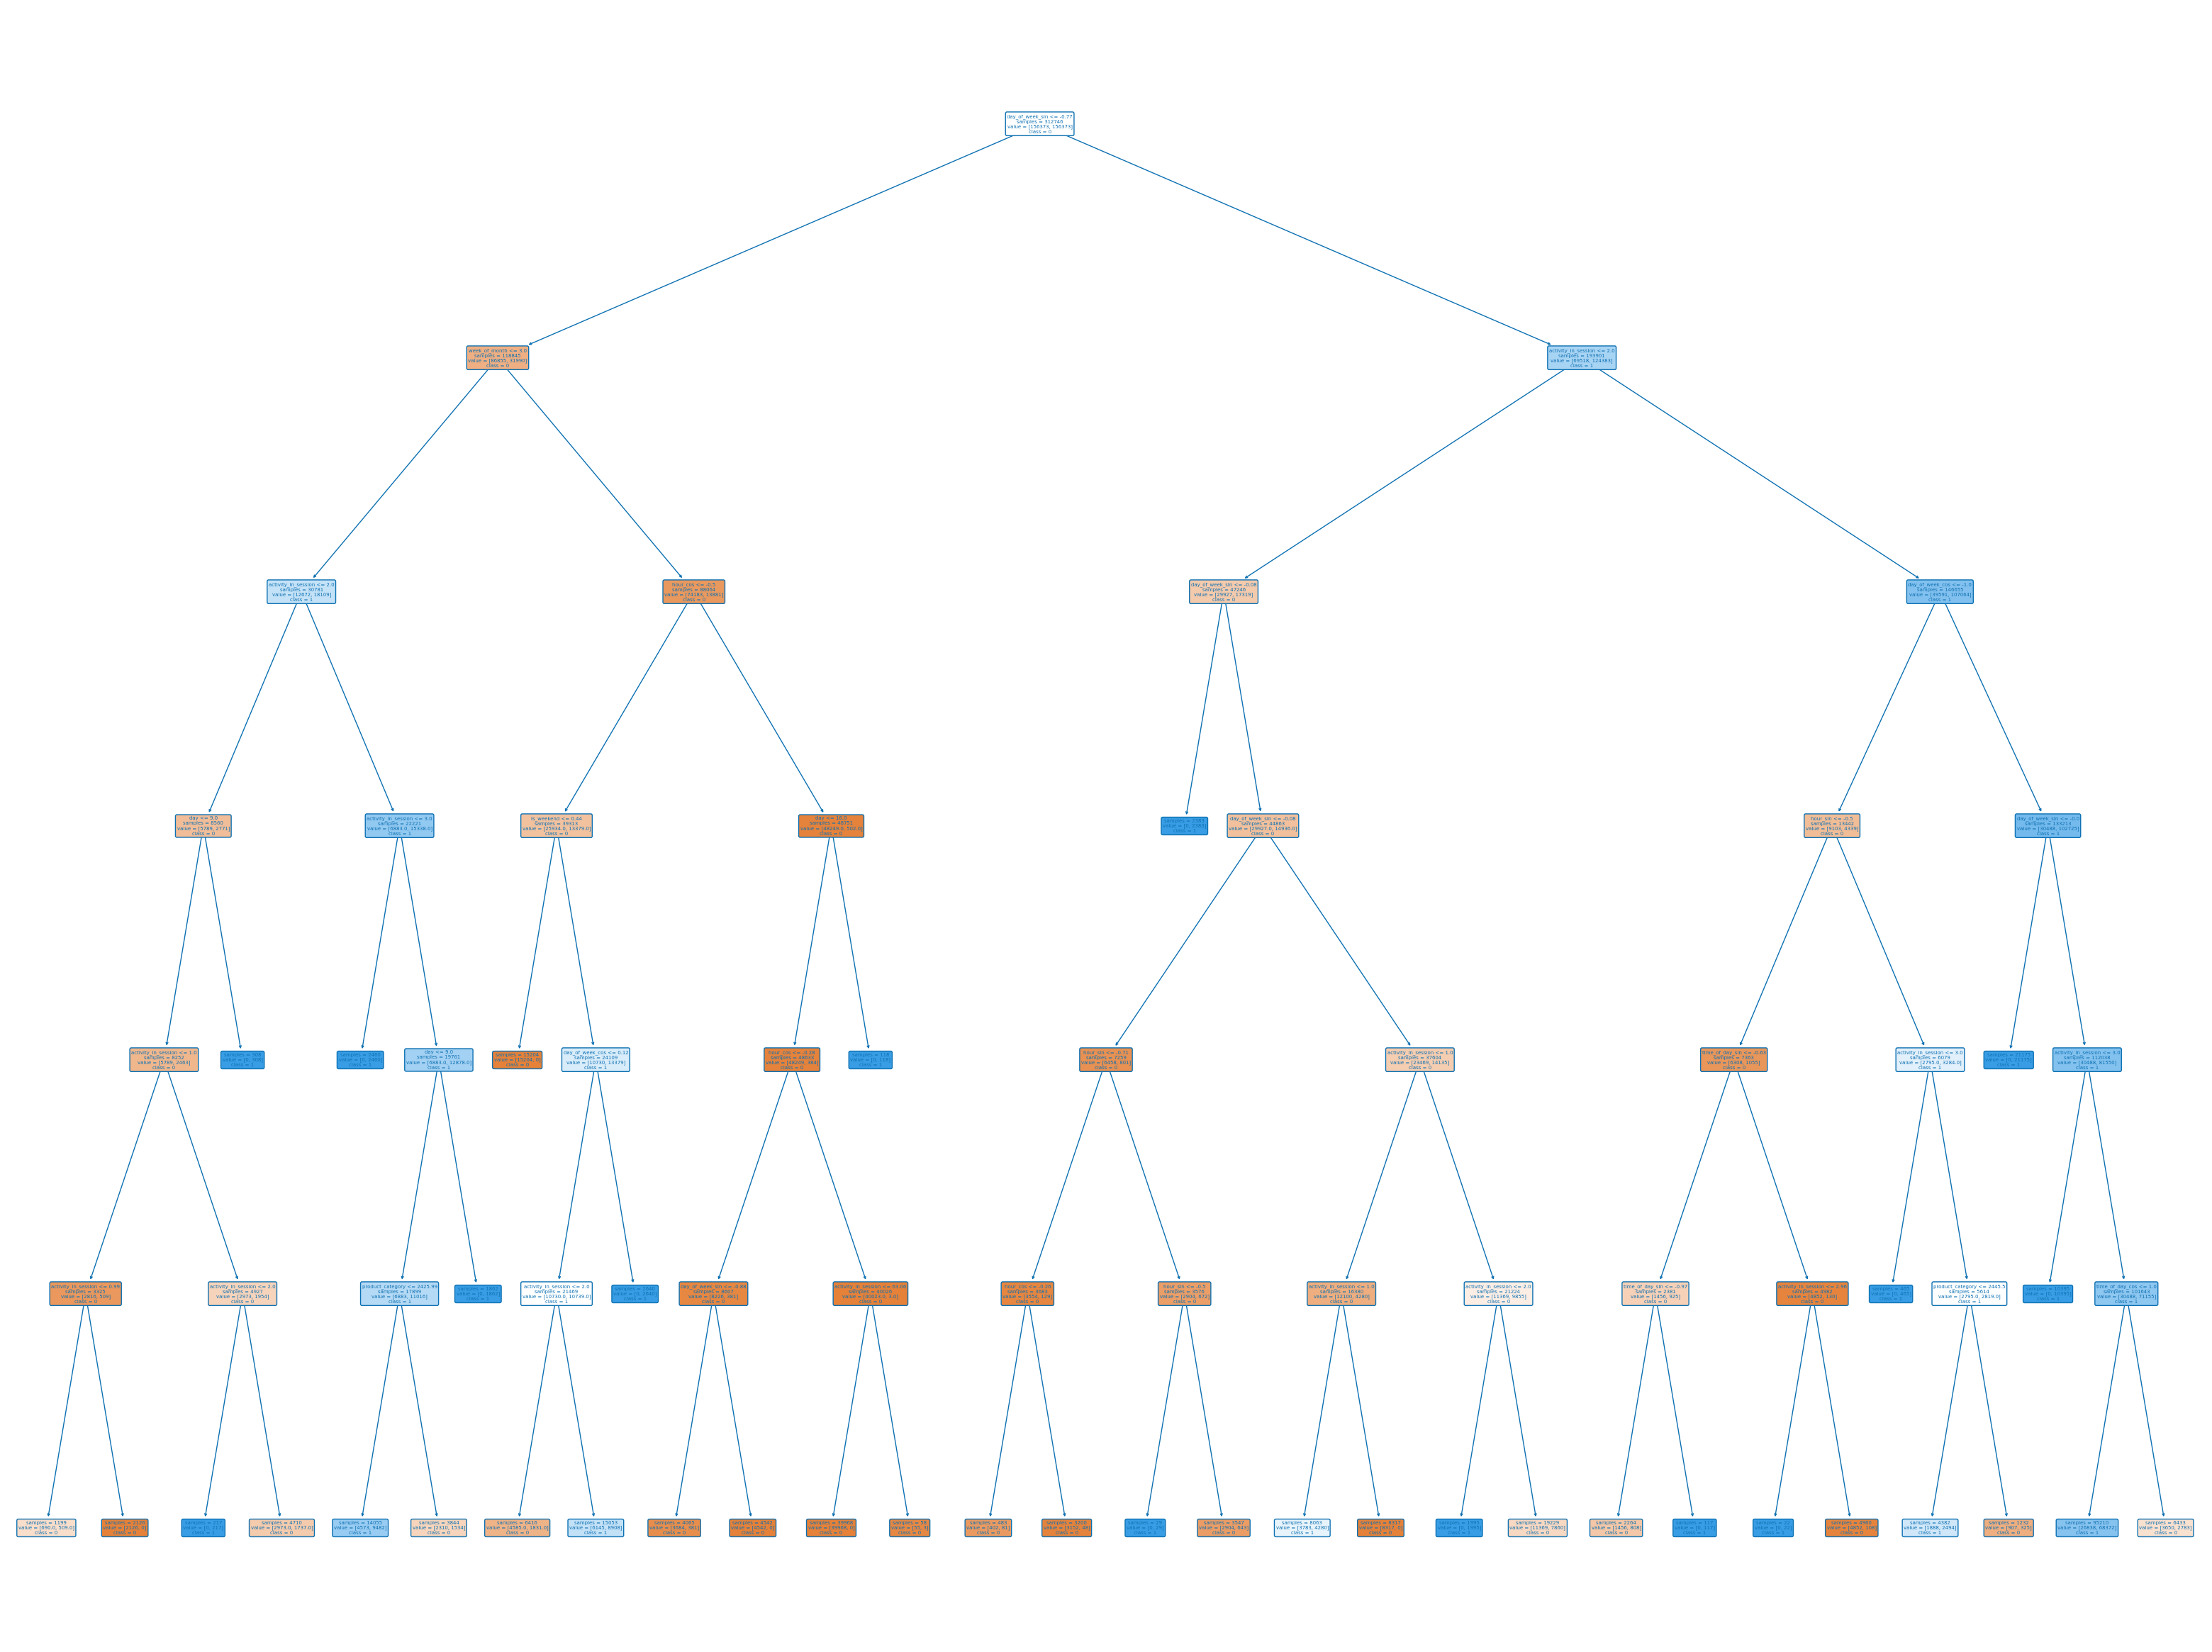

In [48]:
if evaluate==True:
    from sklearn.tree import plot_tree

    figure(figsize=(40, 30))
    plot_tree(
        best_model,
        max_depth=max_depth2show,
        feature_names=vars,
        class_names=st_labels,
        filled=True,
        rounded=True,
        impurity=False,
        precision=2,
    )
    savefig(tree_filename + "_simple.png")

    show()

# Feature Importances

1. day_of_week_sin (0.3471491078222021)
2. activity_in_session (0.25982045847659474)
3. week_of_month (0.11309711193050127)
4. day_of_week_cos (0.08130311379457691)
5. is_weekend (0.07675461754796728)
6. hour_cos (0.06399263012418621)
7. hour_sin (0.015673403081481917)
8. day (0.013669911784554806)
9. time_of_day_cos (0.013129859026621438)
10. product_category (0.008524019485531682)
11. time_of_day_sin (0.006885766925781515)
12. category_code_lvl_2 (0.0)
13. price (0.0)
14. min_cos (0.0)
15. brand_value (0.0)
16. min_sin (0.0)
17. category_code_lvl_1 (0.0)


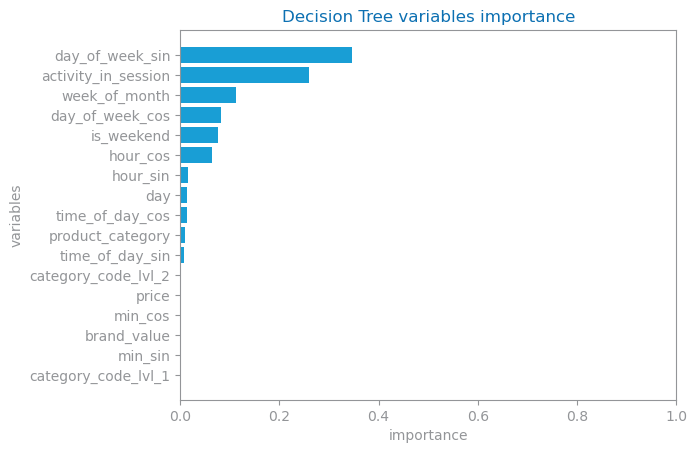

In [43]:
if evaluate==True:
    from numpy import argsort
    from dslabs_functions import plot_horizontal_bar_chart

    importances = best_model.feature_importances_
    indices: list[int] = argsort(importances)[::-1]
    elems: list[str] = []
    imp_values: list[float] = []
    for f in range(len(vars)):
        elems += [vars[indices[f]]]
        imp_values += [importances[indices[f]]]
        print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

    figure()
    plot_horizontal_bar_chart(
        elems,
        imp_values,
        title="Decision Tree variables importance",
        xlabel="importance",
        ylabel="variables",
        percentage=True,
    )
    savefig(f"images/{file_tag}_dt_{eval_metric}_vars_ranking.png")
    show()

# Overfitting

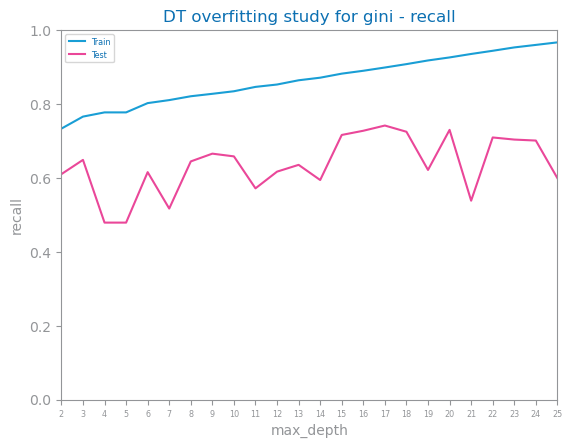

In [44]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit} - {eval_metric}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
